# Boston Marathon Performance Analysis

This notebook help us to analysis a marathon using boston marathon dataset

# Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, shapiro, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [3]:
url = "/content/Athletes.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (17220, 10)
Memory usage: 3.04 MB

Column types:
Bib                 int64
Zip                 int64
Age                 int64
Age Group          object
Gender             object
First Half          int64
Second Half         int64
Finish              int64
Positive Split      int64
Percent Change    float64
dtype: object

Missing values:
Bib               0
Zip               0
Age               0
Age Group         0
Gender            0
First Half        0
Second Half       0
Finish            0
Positive Split    0
Percent Change    0
dtype: int64

Basic statistics:
                Bib           Zip           Age    First Half   Second Half  \
count  17220.000000  17220.000000  17220.000000  17220.000000  17220.000000   
mean   15688.916783  38541.031127     42.217828   6526.240999   7587.674158   
std     8827.226766  34262.257821     12.540766   1270.014789   1779.232288   
min        9.000000    627.000000     18.000000   3795.000000   3961.000000   
25%     7997.75000

# Data Cleaning and Preprocessing

In [7]:
df['time'] = df['First Half'] + df['Second Half']
display(df[['First Half', 'Second Half', 'time']].head())
df['Time_seconds'] = df['Finish']
df = df.dropna(subset=['Time_seconds'])

df['Age_group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '60+'])
df['Pace_per_mile'] = df['Time_seconds'] / 26.2
df['Speed_mph'] = 26.2 / (df['Time_seconds'] / 3600)

df['Performance_category'] = pd.cut(df['Time_seconds'],
                                   bins=[0, 10800, 12600, 14400, 16200, np.inf],
                                   labels=['Elite', 'Sub3', 'Sub3.5', 'Sub4', 'Recreational'])

Q1 = df['Time_seconds'].quantile(0.25)
Q3 = df['Time_seconds'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Time_seconds'] >= lower_bound) & (df['Time_seconds'] <= upper_bound)]

print(f"Cleaned dataset shape: {df.shape}")

,First Half,Second Half,time
0,3832,3961,7793
1,3845,4059,7904
2,3795,4157,7952
3,3997,4065,8062
4,3979,4198,8177


Cleaned dataset shape: (17147, 16)


from matplotlib import pyplot as plt
_df_26['First Half'].plot(kind='hist', bins=20, title='First Half')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_27['Second Half'].plot(kind='hist', bins=20, title='Second Half')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28['time'].plot(kind='hist', bins=20, title='time')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_29.plot(kind='scatter', x='First Half', y='Second Half', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30.plot(kind='scatter', x='Second Half', y='time', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['First Half']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_31.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('First Half')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['Second Half']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_32.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('Second Half')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'time'}, axis=1)
              .sort_values('time', ascending=True))
  xs = counted['time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_33.sort_values('time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_34['First Half'].plot(kind='line', figsize=(8, 4), title='First Half')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_35['Second Half'].plot(kind='line', figsize=(8, 4), title='Second Half')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_36['time'].plot(kind='line', figsize=(8, 4), title='time')
plt.gca().spines[['top', 'right']].set_visible(False)

# Advanced Feature Engineering

In [8]:
df_encoded = df.copy()

le_gender = LabelEncoder()
le_country = LabelEncoder()
le_city = LabelEncoder()

df_encoded['Gender_encoded'] = le_gender.fit_transform(df_encoded['Gender'])
df_encoded['Country_encoded'] = le_country.fit_transform(df_encoded['Zip'])
df_encoded['City_encoded'] = le_city.fit_transform(df_encoded['Zip'])

df_encoded['Age_Gender_interaction'] = df_encoded['Age'] * df_encoded['Gender_encoded']
df_encoded['Age_squared'] = df_encoded['Age'] ** 2
df_encoded['Age_cubed'] = df_encoded['Age'] ** 3

df_encoded['Age_bin'] = pd.cut(df_encoded['Age'], bins=10, labels=False)

median_time = df_encoded['Time_seconds'].median()
df_encoded['Time_ratio_to_median'] = df_encoded['Time_seconds'] / median_time

df_encoded['Fast_runner'] = (df_encoded['Time_seconds'] < df_encoded['Time_seconds'].quantile(0.3)).astype(int)

print("Advanced features created successfully")
print(f"Final feature count: {df_encoded.shape[1]}")

Advanced features created successfully
Final feature count: 25


# Comprehensive Statistical Analysis

In [9]:
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns

normality_results = {}
for col in ['Time_seconds', 'Age', 'Speed_mph']:
    if col in df_encoded.columns:
        stat_jb, p_jb = jarque_bera(df_encoded[col].dropna())
        stat_sw, p_sw = shapiro(df_encoded[col].dropna().sample(min(5000, len(df_encoded))))
        normality_results[col] = {'jarque_bera_p': p_jb, 'shapiro_p': p_sw}

print("Normality test results (p-values):")
for col, results in normality_results.items():
    print(f"{col}: JB={results['jarque_bera_p']:.6f}, SW={results['shapiro_p']:.6f}")

correlation_matrix = df_encoded[numeric_cols].corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nHigh correlation pairs (>0.7): {len(high_corr_pairs)}")

Normality test results (p-values):
Time_seconds: JB=0.000000, SW=0.000000
Age: JB=0.000000, SW=0.000000
Speed_mph: JB=0.000000, SW=0.000000

High correlation pairs (>0.7): 49


# Comprehensive Data Visualization Dashboard

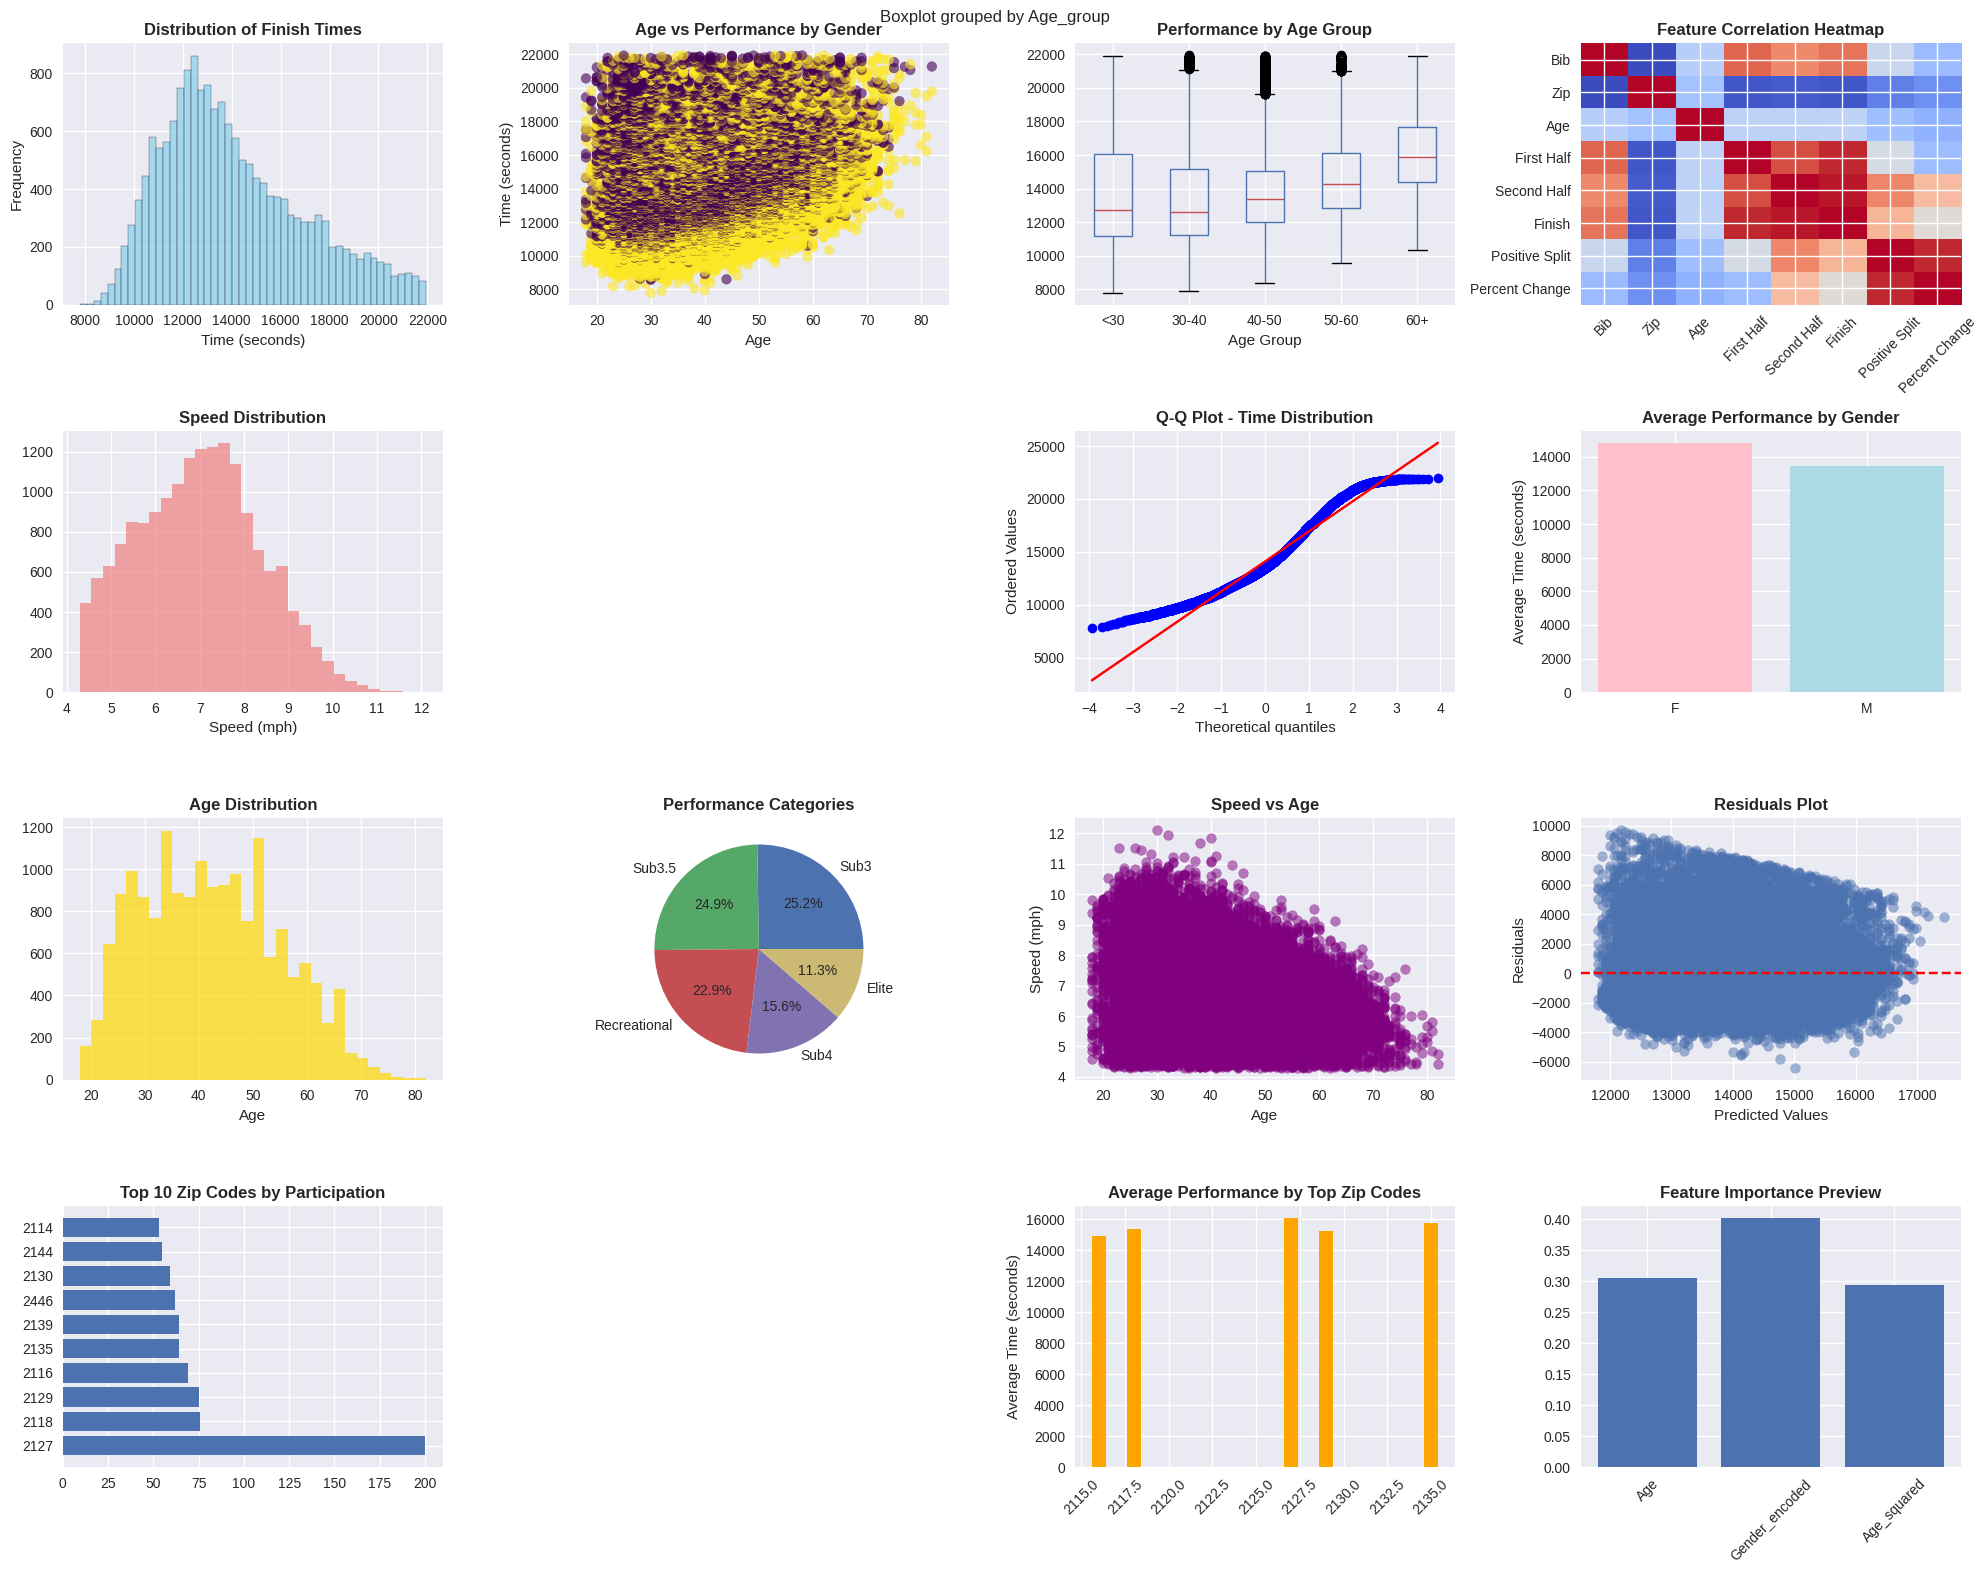

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Boston Marathon Analysis Dashboard', fontsize=20, fontweight='bold')

axes[0,0].hist(df_encoded['Time_seconds'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Finish Times', fontweight='bold')
axes[0,0].set_xlabel('Time (seconds)')
axes[0,0].set_ylabel('Frequency')

scatter = axes[0,1].scatter(df_encoded['Age'], df_encoded['Time_seconds'],
                           c=df_encoded['Gender_encoded'], alpha=0.6, cmap='viridis')
axes[0,1].set_title('Age vs Performance by Gender', fontweight='bold')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Time (seconds)')

df_encoded.boxplot(column='Time_seconds', by='Age_group', ax=axes[0,2])
axes[0,2].set_title('Performance by Age Group', fontweight='bold')
axes[0,2].set_xlabel('Age Group')

im = axes[0,3].imshow(correlation_matrix.iloc[:8, :8], cmap='coolwarm', aspect='auto')
axes[0,3].set_title('Feature Correlation Heatmap', fontweight='bold')
axes[0,3].set_xticks(range(8))
axes[0,3].set_yticks(range(8))
axes[0,3].set_xticklabels(correlation_matrix.columns[:8], rotation=45)
axes[0,3].set_yticklabels(correlation_matrix.columns[:8])

axes[1,0].hist(df_encoded['Speed_mph'], bins=30, alpha=0.7, color='lightcoral')
axes[1,0].set_title('Speed Distribution', fontweight='bold')
axes[1,0].set_xlabel('Speed (mph)')

axes[1,1].set_visible(False)
stats.probplot(df_encoded['Time_seconds'], dist="norm", plot=axes[1,2])
axes[1,2].set_title('Q-Q Plot - Time Distribution', fontweight='bold')

gender_perf = df_encoded.groupby('Gender')['Time_seconds'].mean()
axes[1,3].bar(gender_perf.index, gender_perf.values, color=['pink', 'lightblue'])
axes[1,3].set_title('Average Performance by Gender', fontweight='bold')
axes[1,3].set_ylabel('Average Time (seconds)')

axes[2,0].hist(df_encoded['Age'], bins=30, alpha=0.7, color='gold')
axes[2,0].set_title('Age Distribution', fontweight='bold')
axes[2,0].set_xlabel('Age')

perf_counts = df_encoded['Performance_category'].value_counts()
axes[2,1].pie(perf_counts.values, labels=perf_counts.index, autopct='%1.1f%%')
axes[2,1].set_title('Performance Categories', fontweight='bold')

axes[2,2].scatter(df_encoded['Age'], df_encoded['Speed_mph'], alpha=0.5, c='purple')
axes[2,2].set_title('Speed vs Age', fontweight='bold')
axes[2,2].set_xlabel('Age')
axes[2,2].set_ylabel('Speed (mph)')

X_simple = df_encoded[['Age', 'Gender_encoded']].dropna()
y_simple = df_encoded.loc[X_simple.index, 'Time_seconds']
lr_simple = LinearRegression().fit(X_simple, y_simple)
residuals = y_simple - lr_simple.predict(X_simple)
axes[2,3].scatter(lr_simple.predict(X_simple), residuals, alpha=0.5)
axes[2,3].axhline(y=0, color='red', linestyle='--')
axes[2,3].set_title('Residuals Plot', fontweight='bold')
axes[2,3].set_xlabel('Predicted Values')
axes[2,3].set_ylabel('Residuals')

top_zips = df_encoded['Zip'].value_counts().head(10)
axes[3,0].barh(range(len(top_zips)), top_zips.values)
axes[3,0].set_yticks(range(len(top_zips)))
axes[3,0].set_yticklabels(top_zips.index)
axes[3,0].set_title('Top 10 Zip Codes by Participation', fontweight='bold')

axes[3,1].set_visible(False)

top5_zips = df_encoded['Zip'].value_counts().head(5).index
zip_perf = df_encoded[df_encoded['Zip'].isin(top5_zips)].groupby('Zip')['Time_seconds'].mean()
axes[3,2].bar(zip_perf.index, zip_perf.values, color='orange')
axes[3,2].set_title('Average Performance by Top Zip Codes', fontweight='bold')
axes[3,2].set_ylabel('Average Time (seconds)')
axes[3,2].tick_params(axis='x', rotation=45)

feature_cols = ['Age', 'Gender_encoded', 'Age_squared']
X_preview = df_encoded[feature_cols].dropna()
y_preview = df_encoded.loc[X_preview.index, 'Time_seconds']
rf_preview = RandomForestRegressor(n_estimators=50, random_state=42)
rf_preview.fit(X_preview, y_preview)
axes[3,3].bar(feature_cols, rf_preview.feature_importances_)
axes[3,3].set_title('Feature Importance Preview', fontweight='bold')
axes[3,3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Data Preparation for Machine Learning

In [12]:
feature_columns = ['Age', 'Gender_encoded', 'Country_encoded', 'City_encoded',
                  'Age_Gender_interaction', 'Age_squared', 'Age_cubed', 'Age_bin']

available_features = [col for col in feature_columns if col in df_encoded.columns]
X = df_encoded[available_features].copy()
y = df_encoded['Time_seconds'].copy()

mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X[['Age', 'Gender_encoded']])
poly_feature_names = poly.get_feature_names_out(['Age', 'Gender_encoded'])

X_combined = np.hstack([X.values, X_poly])
all_feature_names = available_features + list(poly_feature_names)

print(f"Final dataset shape: {X_combined.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Total features: {len(all_feature_names)}")

Final dataset shape: (17147, 11)
Target variable shape: (17147,)
Total features: 11


# Multiple Preprocessing Pipelines

In [13]:
preprocessing_strategies = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

X_train_processed = {}
X_test_processed = {}

for name, scaler in preprocessing_strategies.items():
    X_train_processed[name] = scaler.fit_transform(X_train)
    X_test_processed[name] = scaler.transform(X_test)
    print(f"Applied {name} preprocessing")

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Applied standard preprocessing
Applied minmax preprocessing
Applied robust preprocessing
Applied power preprocessing
Applied quantile preprocessing
Training set shape: (13717, 11)
Test set shape: (3430, 11)


# Model Definitions and Hyperparameter Grids

In [14]:
models_and_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'max_iter': [1000, 2000, 5000]
        }
    },
    'elastic_net': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9],
            'max_iter': [1000, 2000]
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['squared_error', 'absolute_error']
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'ada_boost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 1.0],
            'loss': ['linear', 'square', 'exponential']
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
    },
    'knn': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 11, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
    },
    'mlp': {
        'model': MLPRegressor(max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

print(f"Total models to train: {len(models_and_params)}")

Total models to train: 11


# Model Training and Hyperparameter Optimization

In [15]:
model_results = {}
best_models = {}

best_preprocessing = 'robust'
X_train_best = X_train_processed[best_preprocessing]
X_test_best = X_test_processed[best_preprocessing]

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting comprehensive model training and optimization...")
print("=" * 60)

for model_name, model_config in models_and_params.items():
    print(f"\nTraining {model_name.upper()}...")

    model = model_config['model']
    param_grid = model_config['params']

    if param_grid:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=20,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        try:
            random_search.fit(X_train_best, y_train)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_score = -random_search.best_score_

        except Exception as e:
            print(f"Error in hyperparameter optimization for {model_name}: {e}")
            model.fit(X_train_best, y_train)
            best_model = model
            best_params = {}
            cv_scores = cross_val_score(model, X_train_best, y_train,
                                      cv=5, scoring='neg_mean_squared_error')
            cv_score = -cv_scores.mean()
    else:
        try:
            model.fit(X_train_best, y_train)
            best_model = model
            best_params = {}
            cv_scores = cross_val_score(model, X_train_best, y_train,
                                      cv=5, scoring='neg_mean_squared_error')
            cv_score = -cv_scores.mean()
        except Exception as e:
            print(f"Error training {model_name}: {e}")
            continue

    try:
        y_pred_train = best_model.predict(X_train_best)
        y_pred_test = best_model.predict(X_test_best)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)

        def safe_mape(y_true, y_pred):
            mask = y_true != 0
            return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

        train_mape = safe_mape(y_train, y_pred_train)
        test_mape = safe_mape(y_test, y_pred_test)

        model_results[model_name] = {
            'model': best_model,
            'best_params': best_params,
            'cv_rmse': np.sqrt(cv_score),
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_mape': train_mape,
            'test_mape': test_mape,
            'y_pred_train': y_pred_train,
            'y_pred_test': y_pred_test
        }

        best_models[model_name] = best_model

        print(f"✓ {model_name}: CV RMSE = {np.sqrt(cv_score):.2f}, "
              f"Test RMSE = {test_rmse:.2f}, Test R² = {test_r2:.4f}")

    except Exception as e:
        print(f"Error in prediction for {model_name}: {e}")
        continue

print("\n" + "=" * 60)
print("Model training completed!")
print(f"Successfully trained {len(model_results)} models")

Starting comprehensive model training and optimization...

Training LINEAR_REGRESSION...
✓ linear_regression: CV RMSE = 2544.29, Test RMSE = 2563.97, Test R² = 0.2346

Training RIDGE...
✓ ridge: CV RMSE = 2544.27, Test RMSE = 2563.96, Test R² = 0.2346

Training LASSO...
✓ lasso: CV RMSE = 2544.25, Test RMSE = 2564.02, Test R² = 0.2345

Training ELASTIC_NET...
✓ elastic_net: CV RMSE = 2546.14, Test RMSE = 2565.02, Test R² = 0.2339

Training DECISION_TREE...
✓ decision_tree: CV RMSE = 2461.47, Test RMSE = 2428.85, Test R² = 0.3131

Training RANDOM_FOREST...
✓ random_forest: CV RMSE = 2432.26, Test RMSE = 2400.12, Test R² = 0.3293

Training GRADIENT_BOOSTING...
✓ gradient_boosting: CV RMSE = 2415.34, Test RMSE = 2401.15, Test R² = 0.3287

Training ADA_BOOST...
✓ ada_boost: CV RMSE = 2504.21, Test RMSE = 2491.20, Test R² = 0.2774

Training SVR...
✓ svr: CV RMSE = 2522.33, Test RMSE = 2517.83, Test R² = 0.2619

Training KNN...
✓ knn: CV RMSE = 2508.97, Test RMSE = 2486.21, Test R² = 0.2803


# Create results summary DataFrame

In [16]:
results_df = pd.DataFrame({
    model_name: {
        'CV_RMSE': results['cv_rmse'],
        'Train_RMSE': results['train_rmse'],
        'Test_RMSE': results['test_rmse'],
        'Train_R2': results['train_r2'],
        'Test_R2': results['test_r2'],
        'Train_MAE': results['train_mae'],
        'Test_MAE': results['test_mae'],
        'Train_MAPE': results['train_mape'],
        'Test_MAPE': results['test_mape']
    }
    for model_name, results in model_results.items()
}).T

results_df = results_df.sort_values('Test_RMSE')
print("\nTop 5 Models by Test RMSE:")
print(results_df.head()[['Test_RMSE', 'Test_R2', 'Test_MAE']].round(4))


Top 5 Models by Test RMSE:
                   Test_RMSE  Test_R2   Test_MAE
random_forest      2400.1248   0.3293  1831.1006
gradient_boosting  2401.1535   0.3287  1829.1452
mlp                2427.3634   0.3140  1860.9045
decision_tree      2428.8530   0.3131  1848.9896
knn                2486.2127   0.2803  1892.4602


# Advanced Ensemble Methods

In [17]:
print("Creating advanced ensemble methods...")

top_models = results_df.head(5).index.tolist()
ensemble_models = [best_models[name] for name in top_models if name in best_models]

if len(ensemble_models) >= 3:
    voting_regressor = VotingRegressor([
        (name, model) for name, model in zip(top_models[:3], ensemble_models[:3])
    ])
    voting_regressor.fit(X_train_best, y_train)

    stacking_regressor = StackingRegressor(
        estimators=[(name, model) for name, model in zip(top_models[:4], ensemble_models[:4])],
        final_estimator=Ridge(alpha=1.0),
        cv=5
    )
    stacking_regressor.fit(X_train_best, y_train)

    weights = []
    for name in top_models[:3]:
        if name in model_results:
            rmse = model_results[name]['test_rmse']
            weight = 1.0 / (rmse + 1e-8)
            weights.append(weight)

    weights = np.array(weights)
    weights = weights / weights.sum()

    weighted_pred_test = np.zeros(len(y_test))
    weighted_pred_train = np.zeros(len(y_train))

    for i, (name, model) in enumerate(zip(top_models[:len(weights)], ensemble_models[:len(weights)])):
        if name in model_results:
            weighted_pred_test += weights[i] * model_results[name]['y_pred_test']
            weighted_pred_train += weights[i] * model_results[name]['y_pred_train']

    ensemble_results = {}

    voting_pred_train = voting_regressor.predict(X_train_best)
    voting_pred_test = voting_regressor.predict(X_test_best)

    ensemble_results['voting'] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, voting_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, voting_pred_test)),
        'train_r2': r2_score(y_train, voting_pred_train),
        'test_r2': r2_score(y_test, voting_pred_test)
    }

    stacking_pred_train = stacking_regressor.predict(X_train_best)
    stacking_pred_test = stacking_regressor.predict(X_test_best)

    ensemble_results['stacking'] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, stacking_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, stacking_pred_test)),
        'train_r2': r2_score(y_train, stacking_pred_train),
        'test_r2': r2_score(y_test, stacking_pred_test)
    }

    ensemble_results['weighted'] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, weighted_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, weighted_pred_test)),
        'train_r2': r2_score(y_train, weighted_pred_train),
        'test_r2': r2_score(y_test, weighted_pred_test)
    }

    print("Ensemble Methods Results:")
    for method, results in ensemble_results.items():
        print(f"{method.upper()}: Test RMSE = {results['test_rmse']:.2f}, "
              f"Test R² = {results['test_r2']:.4f}")

    model_results['voting_ensemble'] = {
        'model': voting_regressor,
        'test_rmse': ensemble_results['voting']['test_rmse'],
        'test_r2': ensemble_results['voting']['test_r2'],
        'y_pred_test': voting_pred_test,
        'y_pred_train': voting_pred_train
    }

    model_results['stacking_ensemble'] = {
        'model': stacking_regressor,
        'test_rmse': ensemble_results['stacking']['test_rmse'],
        'test_r2': ensemble_results['stacking']['test_r2'],
        'y_pred_test': stacking_pred_test,
        'y_pred_train': stacking_pred_train
    }

    model_results['weighted_ensemble'] = {
        'test_rmse': ensemble_results['weighted']['test_rmse'],
        'test_r2': ensemble_results['weighted']['test_r2'],
        'y_pred_test': weighted_pred_test,
        'y_pred_train': weighted_pred_train
    }

    custom_ensemble_models = []
    custom_ensemble_names = []

    for name in ['random_forest', 'gradient_boosting', 'svr']:
        if name in best_models:
            custom_ensemble_models.append(best_models[name])
            custom_ensemble_names.append(name)

    if len(custom_ensemble_models) >= 2:
        custom_voting = VotingRegressor([(name, model) for name, model in zip(custom_ensemble_names, custom_ensemble_models)])
        custom_voting.fit(X_train_best, y_train)

        custom_pred_test = custom_voting.predict(X_test_best)
        custom_pred_train = custom_voting.predict(X_train_best)

        model_results['custom_ensemble'] = {
            'model': custom_voting,
            'test_rmse': np.sqrt(mean_squared_error(y_test, custom_pred_test)),
            'test_r2': r2_score(y_test, custom_pred_test),
            'y_pred_test': custom_pred_test,
            'y_pred_train': custom_pred_train
        }

        print(f"Custom Ensemble: Test RMSE = {model_results['custom_ensemble']['test_rmse']:.2f}")

print("Advanced ensemble methods completed successfully!")

Creating advanced ensemble methods...
Ensemble Methods Results:
VOTING: Test RMSE = 2402.15, Test R² = 0.3281
STACKING: Test RMSE = 2402.12, Test R² = 0.3282
WEIGHTED: Test RMSE = 2400.79, Test R² = 0.3289
Custom Ensemble: Test RMSE = 2416.57
Advanced ensemble methods completed successfully!


# Feature Importance and Model Interpretability Analysis

Performing feature importance and interpretability analysis...
Computing permutation importance for linear_regression...
Computing permutation importance for ridge...
Computing permutation importance for lasso...
Computing permutation importance for elastic_net...
Computing permutation importance for decision_tree...


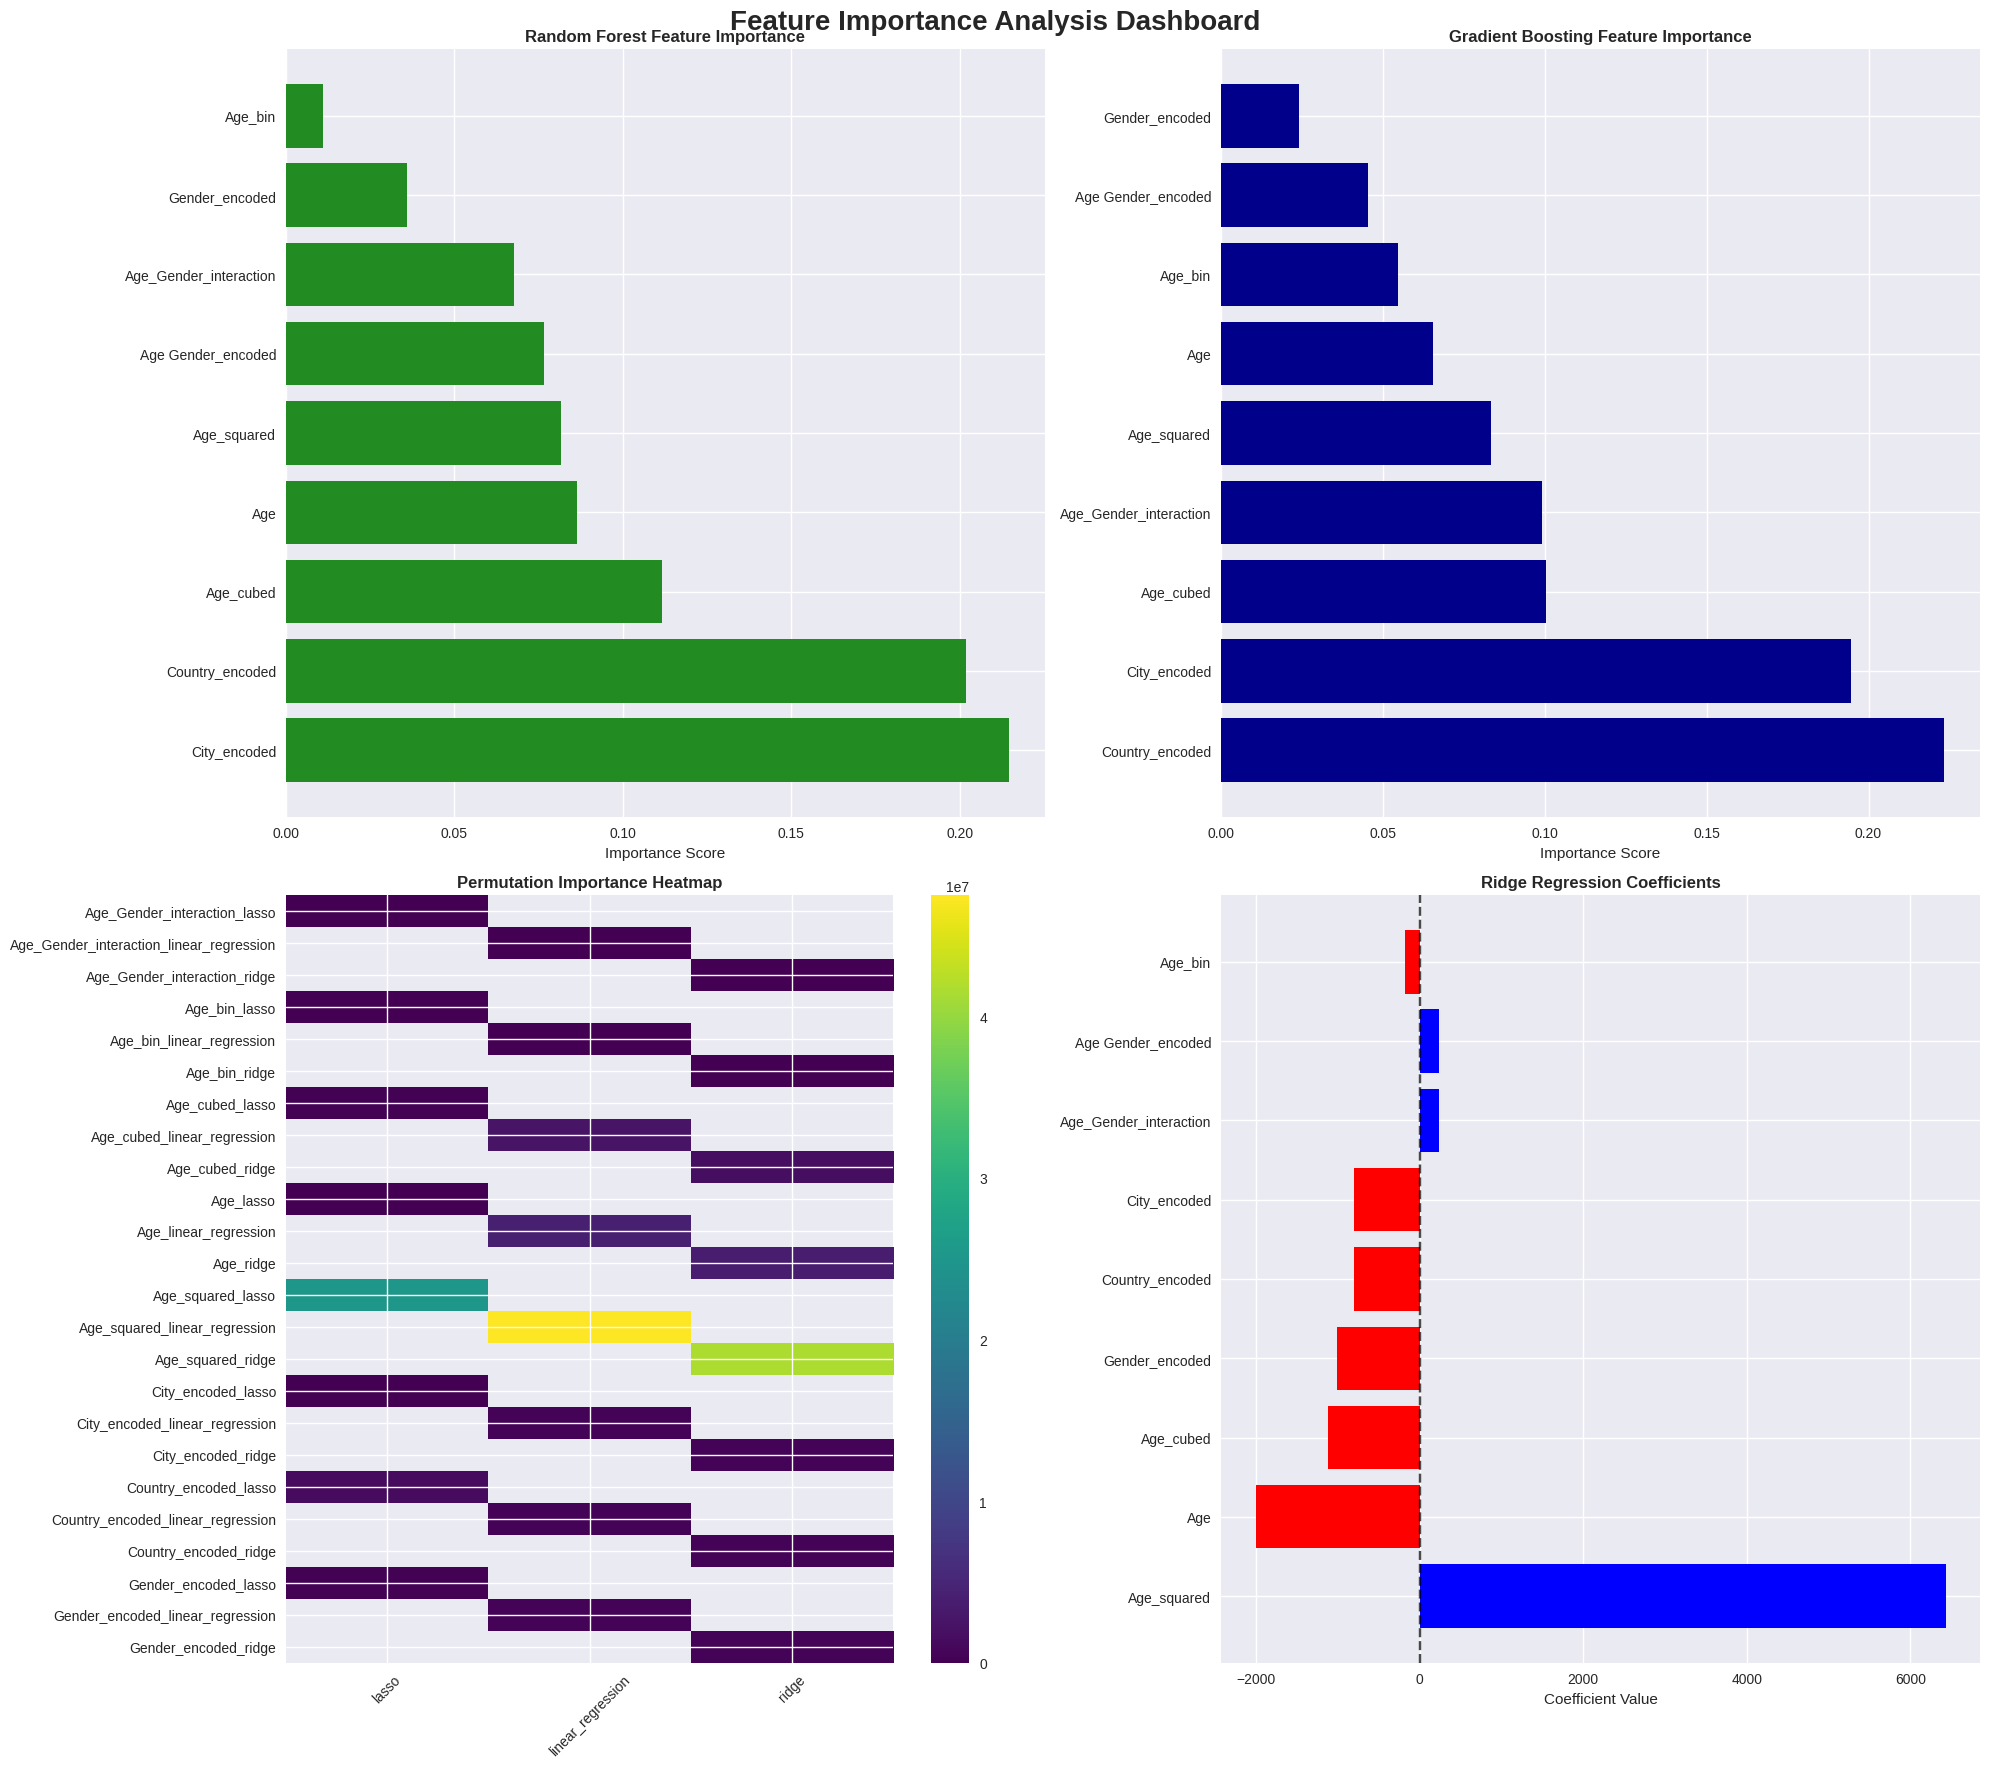

In [22]:
print("Performing feature importance and interpretability analysis...")

feature_importance_results = {}
tree_based_models = ['decision_tree', 'random_forest', 'gradient_boosting']
for model_name in tree_based_models:
    if model_name in best_models:
        model = best_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance_scores = model.feature_importances_
            feature_importance_results[model_name] = dict(zip(all_feature_names, importance_scores)) # Use all_feature_names

permutation_importance_results = {}
top_5_models = list(model_results.keys())[:5]

for model_name in top_5_models:
    if model_name in best_models:
        print(f"Computing permutation importance for {model_name}...")
        model = best_models[model_name]

        try:
            perm_importance = permutation_importance(
                model, X_test_best, y_test,
                n_repeats=10, random_state=42,
                scoring='neg_mean_squared_error'
            )

            importance_mean = perm_importance.importances_mean
            importance_std = perm_importance.importances_std

            permutation_importance_results[model_name] = {
                'importance_mean': importance_mean,
                'importance_std': importance_std,
                'feature_names': all_feature_names
            }

        except Exception as e:
            print(f"Error computing permutation importance for {model_name}: {e}")

linear_models = ['linear_regression', 'ridge', 'lasso', 'elastic_net']
coefficient_results = {}

for model_name in linear_models:
    if model_name in best_models:
        model = best_models[model_name]
        if hasattr(model, 'coef_'):
            coefficients = model.coef_
            coefficient_results[model_name] = dict(zip(all_feature_names, coefficients)) # Use all_feature_names

fig, axes = plt.subplots(2, 2, figsize=(20, 18))
fig.suptitle('Feature Importance Analysis Dashboard', fontsize=20, fontweight='bold')

if 'random_forest' in feature_importance_results:
    rf_importance = feature_importance_results['random_forest']
    sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    features, importances = zip(*sorted_features)

    axes[0,0].barh(range(len(features)), importances, color='forestgreen')
    axes[0,0].set_yticks(range(len(features)))
    axes[0,0].set_yticklabels(features)
    axes[0,0].set_title('Random Forest Feature Importance', fontweight='bold')
    axes[0,0].set_xlabel('Importance Score')

if 'gradient_boosting' in feature_importance_results:
    gb_importance = feature_importance_results['gradient_boosting']
    sorted_features = sorted(gb_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    features, importances = zip(*sorted_features)

    axes[0,1].barh(range(len(features)), importances, color='darkblue')
    axes[0,1].set_yticks(range(len(features)))
    axes[0,1].set_yticklabels(features)
    axes[0,1].set_title('Gradient Boosting Feature Importance', fontweight='bold')
    axes[0,1].set_xlabel('Importance Score')

if permutation_importance_results:
    model_names = list(permutation_importance_results.keys())[:3]
    importance_data = []

    for model_name in model_names:
        importance_mean = permutation_importance_results[model_name]['importance_mean']
        feature_names_perm = permutation_importance_results[model_name]['feature_names'] # Use correct variable name
        top_indices = np.argsort(importance_mean)[-10:]

        for idx in top_indices:
            importance_data.append({
                'model': model_name,
                'feature': feature_names_perm[idx],
                'importance': importance_mean[idx]
            })

    if importance_data:
        perm_df = pd.DataFrame(importance_data)
        perm_df['feature_model'] = perm_df['feature'] + '_' + perm_df['model']
        perm_df = perm_df.drop_duplicates(subset=['feature', 'model'])
        pivot_df = perm_df.pivot(index='feature_model', columns='model', values='importance')

        im = axes[1,0].imshow(pivot_df.values, cmap='viridis', aspect='auto')
        axes[1,0].set_xticks(range(len(pivot_df.columns)))
        axes[1,0].set_yticks(range(len(pivot_df.index)))
        axes[1,0].set_xticklabels(pivot_df.columns, rotation=45)
        axes[1,0].set_yticklabels(pivot_df.index)
        axes[1,0].set_title('Permutation Importance Heatmap', fontweight='bold')
        plt.colorbar(im, ax=axes[1,0])

if 'ridge' in coefficient_results:
    ridge_coef = coefficient_results['ridge']
    sorted_coef = sorted(ridge_coef.items(), key=lambda x: abs(x[1]), reverse=True)[:15]
    features, coefficients = zip(*sorted_coef)

    colors = ['red' if c < 0 else 'blue' for c in coefficients]
    axes[1,1].barh(range(len(features)), coefficients, color=colors)
    axes[1,1].set_yticks(range(len(features)))
    axes[1,1].set_yticklabels(features)
    axes[1,1].set_title('Ridge Regression Coefficients', fontweight='bold')
    axes[1,1].set_xlabel('Coefficient Value')
    axes[1,1].axvline(x=0, color='black', linestyle='--', alpha=0.7)

if len(permutation_importance_results) >= 2:
    model1, model2 = list(permutation_importance_results.keys())[:2]
    imp1 = permutation_importance_results[model1]['importance_mean']
    imp2 = permutation_importance_results[model2]['importance_mean']
top_features_summary = {}
for model_name, importance_dict in feature_importance_results.items():
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_features_summary[model_name] = [f[0] for f in sorted_features[:5]]

plt.tight_layout()
plt.show()